In [1]:
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.impute import SimpleImputer
lr = 0.3
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix   
import math

In [2]:
df = pd.read_csv("diabetes2.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df["SkinThickness"] = df["SkinThickness"].replace(0,df["SkinThickness"].mean())
df["Insulin"] = df["Insulin"].replace(0,df["Insulin"].mean())
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35.000000,79.799479,33.6,0.627,50,1
1,1,85,66,29.000000,79.799479,26.6,0.351,31,0
2,8,183,64,20.536458,79.799479,23.3,0.672,32,1
3,1,89,66,23.000000,94.000000,28.1,0.167,21,0
4,0,137,40,35.000000,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48.000000,180.000000,32.9,0.171,63,0
764,2,122,70,27.000000,79.799479,36.8,0.340,27,0
765,5,121,72,23.000000,112.000000,26.2,0.245,30,0
766,1,126,60,20.536458,79.799479,30.1,0.349,47,1


In [6]:
X = df.drop(["Outcome"], axis = 1)
y = df["Outcome"]

In [7]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,train_size = 0.8, random_state =42)

In [8]:
import xgboost as xgb

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions with XGBoost
xgb_preds = xgb_model.predict(X_test)

# Evaluate XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')


XGBoost Accuracy: 0.7403


In [9]:
cross_validation_scores = cross_val_score(xgb_model, X_train, y_train, cv = 10,  scoring='accuracy')
print(f"Cross-Validation Scores: {cross_validation_scores}")

Cross-Validation Scores: [0.74193548 0.77419355 0.80645161 0.80645161 0.7704918  0.80327869
 0.72131148 0.75409836 0.81967213 0.72131148]


In [10]:
# Initializing the scaler for neural network input
scaler = StandardScaler()

# Scale the data for Neural Network
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Creating empty lists to store results
xgb_accuracies = []
nn_accuracies = []
ensemble_accuracies = []

In [12]:
 # Neural Network model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
nn_model = Sequential([
     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
     Dense(32, activation='relu'),
     Dense(1, activation='sigmoid')  
    ])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the neural network
nn_model.fit(X_train_scaled, y_train, epochs= 50, batch_size= 64, verbose=0)
    
    # Neural Network predictions and evaluation
nn_preds = nn_model.predict(X_test_scaled).round().astype(int).reshape(-1)
nn_accuracy = accuracy_score(y_test, nn_preds)
nn_accuracies.append(nn_accuracy)

C:\Users\Samuel Gbenga FALUYI\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [13]:
# XGBoost model
import xgboost as xgb
from sklearn.metrics import accuracy_score
import tensorflow as tf
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
    
# XGBoost predictions and evaluation
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_accuracies.append(xgb_accuracy)
    

In [14]:
# Ensemble model using weighted average (can be modified to stacking)
ensemble_preds = (0.5 * xgb_preds + 0.5 * nn_preds).round()
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_accuracies.append(ensemble_accuracy)


In [15]:
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}, Neural Network Accuracy: {nn_accuracy:.4f}, Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Calculate the mean accuracy across folds
print(f"\nMean XGBoost Accuracy: {np.mean(xgb_accuracies):.4f}")
print(f"Mean Neural Network Accuracy: {np.mean(nn_accuracies):.4f}")
print(f"Mean Ensemble Accuracy: {np.mean(ensemble_accuracies):.4f}")

XGBoost Accuracy: 0.7403, Neural Network Accuracy: 0.7532, Ensemble Accuracy: 0.7597

Mean XGBoost Accuracy: 0.7403
Mean Neural Network Accuracy: 0.7532
Mean Ensemble Accuracy: 0.7597


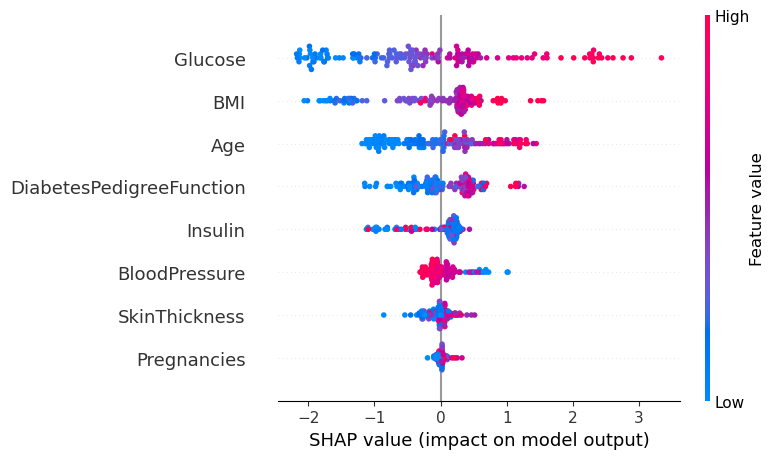

In [16]:
import shap

# Assuming 'X_test' is a DataFrame
# Create SHAP explainer for XGBoost
explainer_xgb = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values_xgb = explainer_xgb(X_test)

# SHAP summary plot for XGBoost, explicitly passing feature names from the DataFrame
shap.summary_plot(shap_values_xgb, X_test, feature_names=X_test.columns)



C:\Users\Samuel Gbenga FALUYI\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


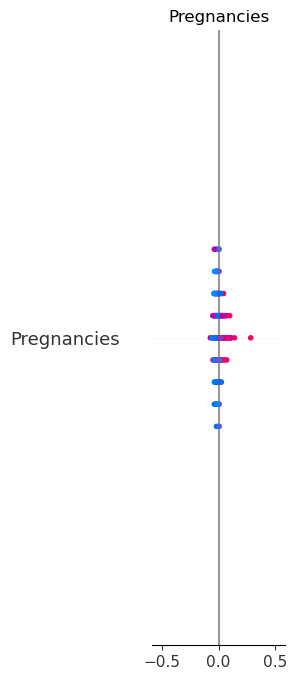

In [17]:
# Create SHAP explainer for Neural Network
explainer_nn = shap.DeepExplainer(nn_model, X_train_scaled)
shap_values_nn = explainer_nn.shap_values(X_test_scaled)

# SHAP summary plot for Neural Network
shap.summary_plot(shap_values_nn, X_test_scaled, feature_names = X_test.columns)


In [18]:
shap.initjs()

shap.force_plot(shap_values_xgb, X_test, feature_names = X_test.columns)
#shap.force_plot(explainer_nn.expected_value, shap_values_nn, X_test_scaled,feature_names = X_test.columns)